In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)

import numpy as np
np.random.seed = 42

In [2]:
import h5py
f = h5py.File("higgs/higgsML_nominal.h5", "r")
data_nom = f["nominal"].value
f = h5py.File("higgs/higgsML_systematic_TES10.h5", "r")
# f = h5py.File("higgs/higgsML_systematic_WNorm10.h5", "r")
data_sys = f["systematic"].value
labels = f["labels"].value

In [3]:
labels

array([b'EventId', b'DER_mass_MMC', b'DER_mass_transverse_met_lep',
       b'DER_mass_vis', b'DER_pt_h', b'DER_deltaeta_jet_jet',
       b'DER_mass_jet_jet', b'DER_prodeta_jet_jet', b'DER_deltar_tau_lep',
       b'DER_pt_tot', b'DER_sum_pt', b'DER_pt_ratio_lep_tau',
       b'DER_met_phi_centrality', b'DER_lep_eta_centrality', b'PRI_tau_pt',
       b'PRI_tau_eta', b'PRI_tau_phi', b'PRI_lep_pt', b'PRI_lep_eta',
       b'PRI_lep_phi', b'PRI_met', b'PRI_met_phi', b'PRI_met_sumet',
       b'PRI_jet_num', b'PRI_jet_leading_pt', b'PRI_jet_leading_eta',
       b'PRI_jet_leading_phi', b'PRI_jet_subleading_pt',
       b'PRI_jet_subleading_eta', b'PRI_jet_subleading_phi',
       b'PRI_jet_all_pt', b'Weight', b'Label', b'origWeight',
       b'detailLabel'], 
      dtype='|S27')

In [36]:
X_nom = data_nom[:, 1:-4]
y_nom = data_nom[:, -3]
w_nom = data_nom[:, -4]

X_sys = data_sys[:, 1:-4]
y_sys = data_sys[:, -3]
w_sys = data_sys[:, -4]

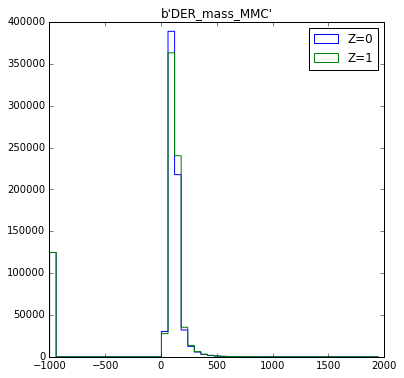

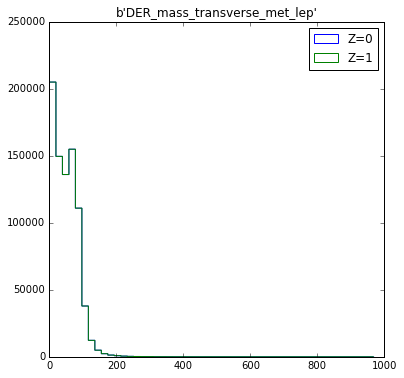

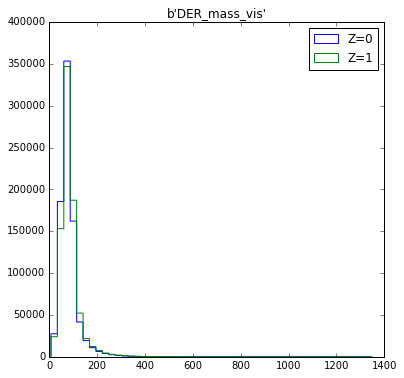

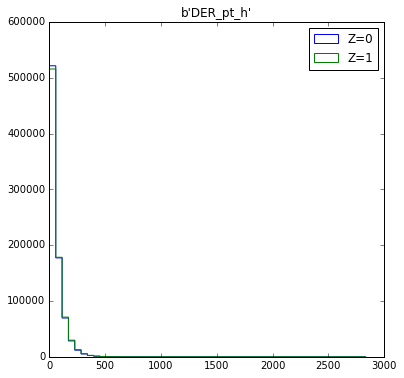

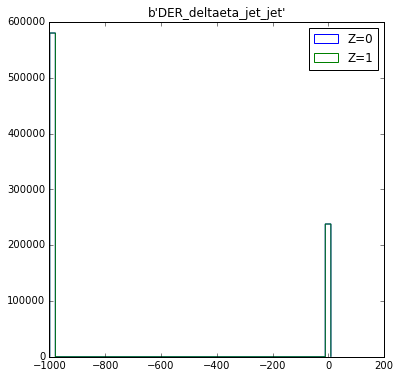

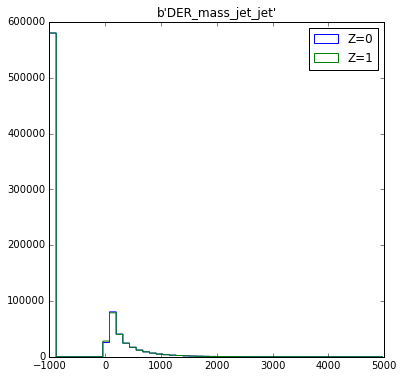

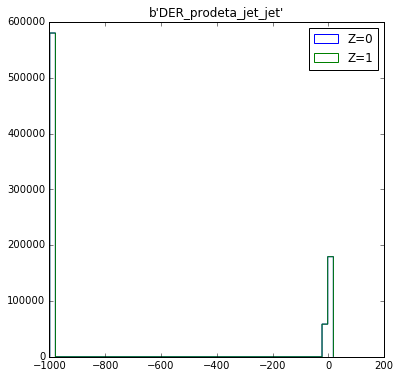

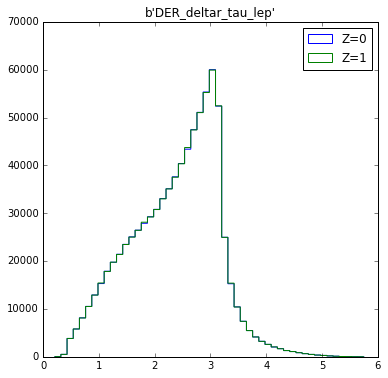

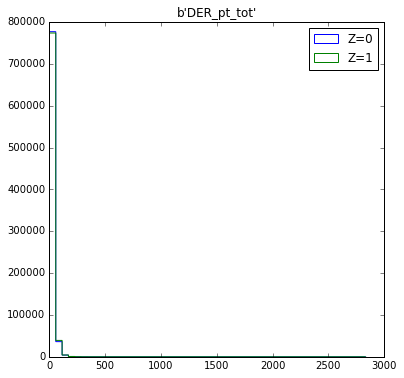

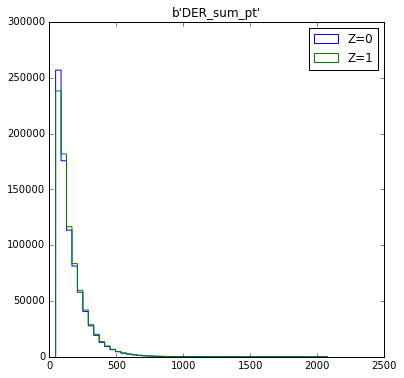

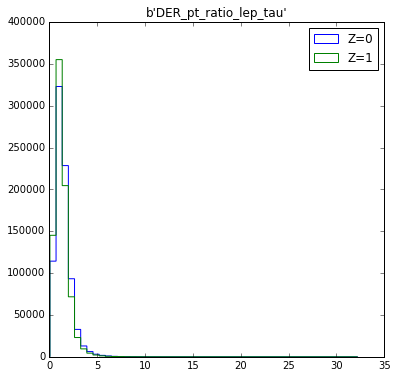

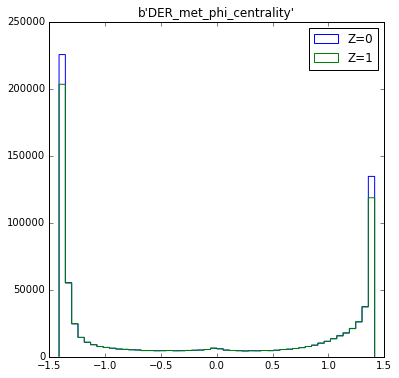

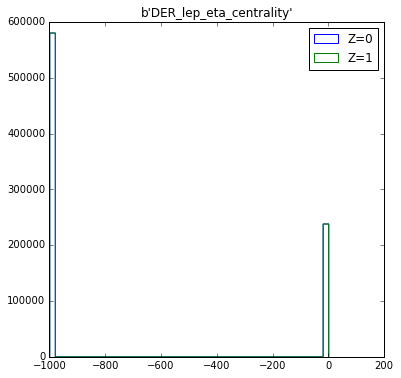

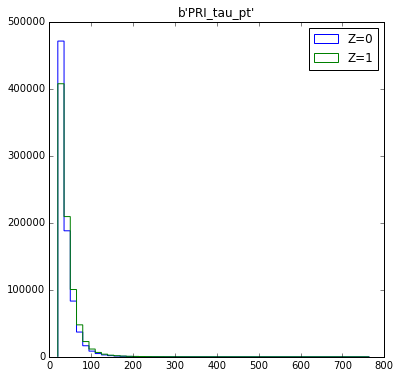

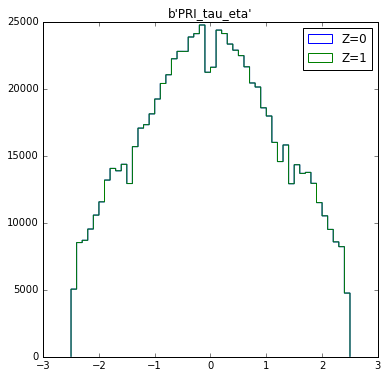

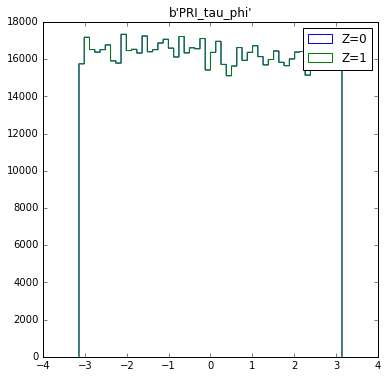

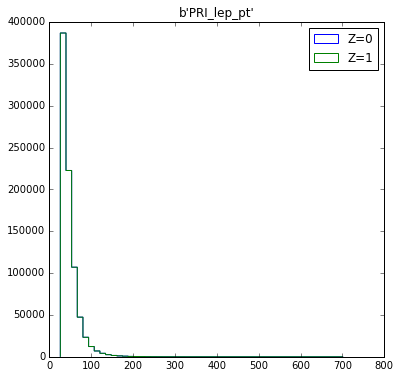

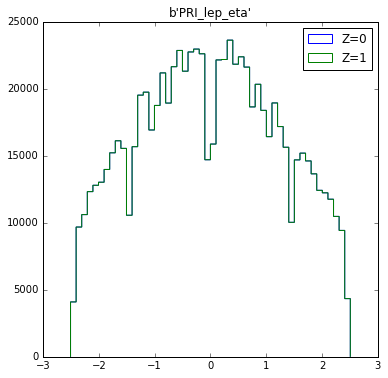

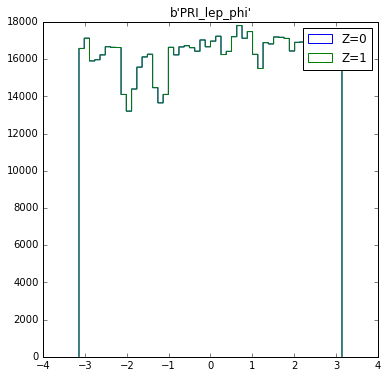

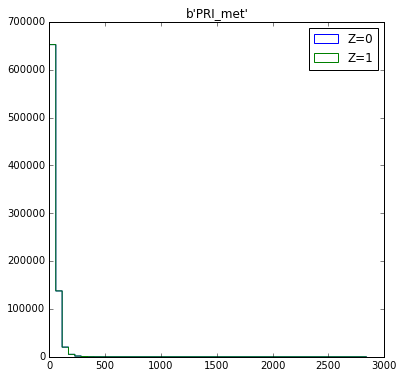

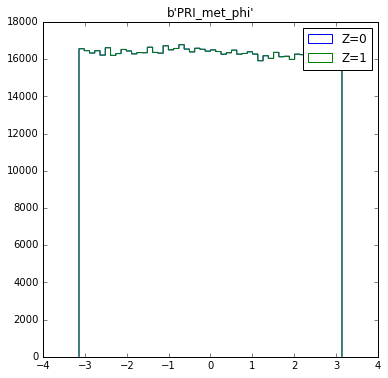

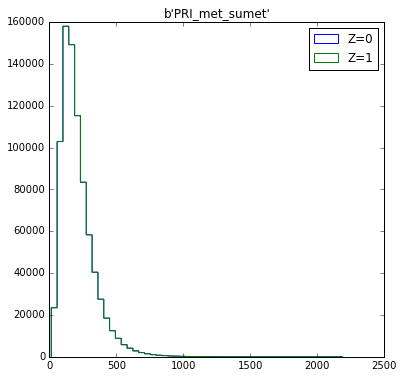

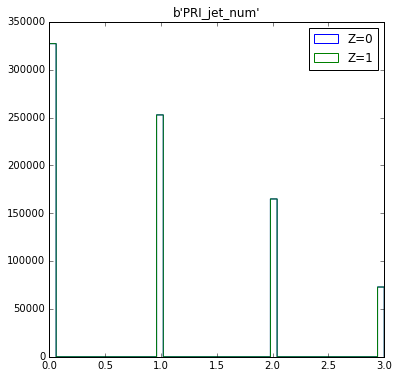

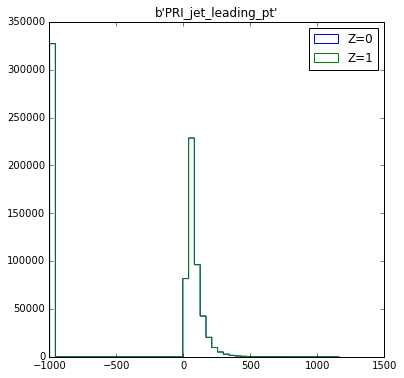

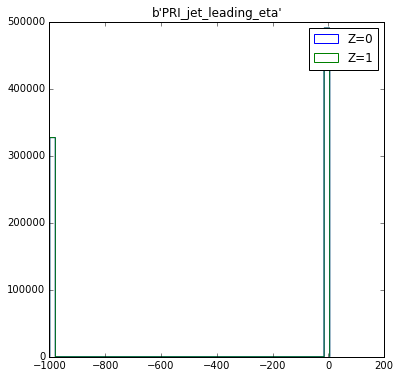

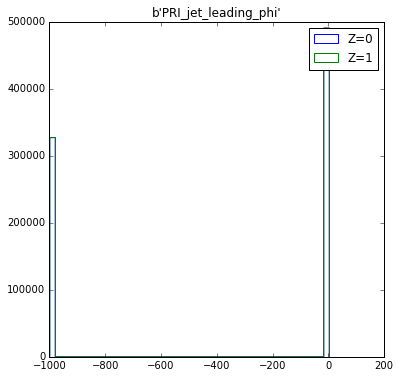

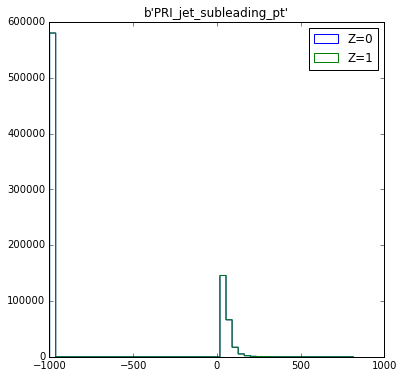

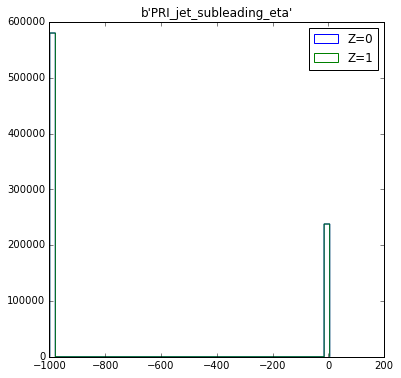

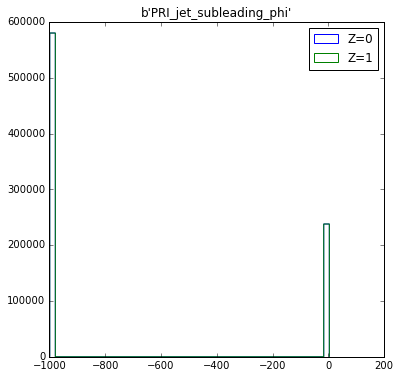

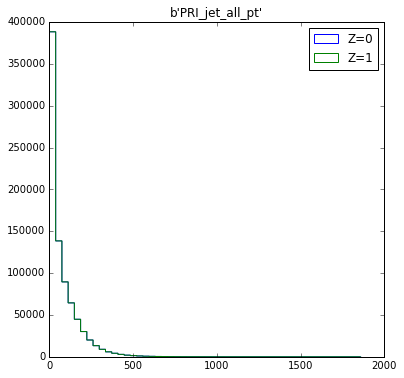

In [37]:
for i in range(X_nom.shape[1]):
    _, r, _ = plt.hist(X_nom[:, i], histtype="step", bins=50, label="Z=0")
    plt.hist(X_sys[:, i], bins=r, histtype="step", label="Z=1")
    plt.legend()
    plt.title(labels[1+i])
    #plt.savefig("hist-%s.png" % labels[1+i])
    plt.show()

In [40]:
X = np.vstack((X_nom, X_sys))
y = np.concatenate((y_nom, y_sys))
z = np.zeros(len(X))
z[len(X_nom):] = 1

from keras.utils import np_utils
z = np_utils.to_categorical(z.astype(np.int))

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import make_pipeline
tf = make_pipeline(Imputer(missing_values=-999., strategy="mean"), StandardScaler())

X = tf.fit_transform(X)

In [41]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=20000)

In [42]:
X_train.shape, X_test.shape, z_train.shape

((1616476, 30), (20000, 30), (1616476, 2))

In [43]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(48, activation="tanh")(inputs)
Dx = Dense(48, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

Rx = D(inputs)
Rx = Dense(48, activation="relu")(Rx)
Rx = Dense(48, activation="relu")(Rx)
Rx = Dense(z.shape[1], activation="softmax")(Rx)
R = Model(input=[inputs], output=[Rx])

In [44]:
from keras.optimizers import SGD, Adam
import keras.backend as K

lam = 100.0

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        return c * K.categorical_crossentropy(z_pred, z_true)
    return loss_R

opt_D = Adam()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

opt_DRf = SGD(momentum=0) 
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=1.0), 
                  make_loss_R(c=-lam)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = SGD(momentum=0) 
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=1.0)], 
            optimizer=opt_DfR)

In [45]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
model_5 (Model)                  (None, 1)             3889        input_2[0][0]                    
____________________________________________________________________________________________________
model_6 (Model)                  (None, 2)             6435        input_2[0][0]                    
Total params: 10324
____________________________________________________________________________________________________


In [46]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
model_6 (Model)                  (None, 2)             6435        input_2[0][0]                    
Total params: 6435
____________________________________________________________________________________________________


In [47]:
# Pretraining of D
D.trainable = True
R.trainable = False
D.fit(X_train[z_train[:, 0] == 1], y_train[z_train[:, 0] == 1], nb_epoch=5)

Epoch 1/5
808317/808317 [==============================] - 12s - loss: 0.3723    
Epoch 2/5
808317/808317 [==============================] - 12s - loss: 0.3591    
Epoch 3/5
808317/808317 [==============================] - 10s - loss: 0.3562    
Epoch 4/5
808317/808317 [==============================] - 10s - loss: 0.3544    
Epoch 5/5
808317/808317 [==============================] - 11s - loss: 0.3533    


In [48]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, D.predict(X_test))

0.90910389498498279

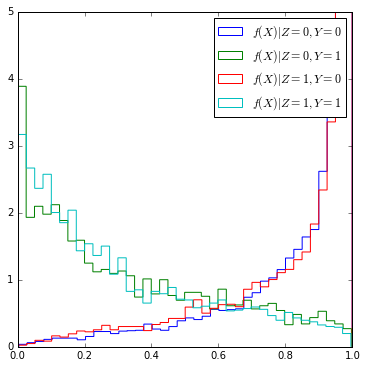

In [49]:
X_test_z0 = X_test[z_test[:, 0] == 1]
y_test_z0 = y_test[z_test[:, 0] == 1]
X_test_z1 = X_test[z_test[:, 1] == 1]
y_test_z1 = y_test[z_test[:, 1] == 1]

plt.hist(1. - D.predict(X_test_z0[y_test_z0 == 0]), bins=40, normed=1, histtype="step", label="$f(X)|Z=0,Y=0$")
plt.hist(1. - D.predict(X_test_z0[y_test_z0 == 1]), bins=40, normed=1, histtype="step", label="$f(X)|Z=0,Y=1$")
plt.hist(1. - D.predict(X_test_z1[y_test_z1 == 0]), bins=40, normed=1, histtype="step", label="$f(X)|Z=1,Y=0$")
plt.hist(1. - D.predict(X_test_z1[y_test_z1 == 1]), bins=40, normed=1, histtype="step", label="$f(X)|Z=1,Y=1$")
plt.legend(loc="best")
plt.ylim(0, 5.)
plt.show()

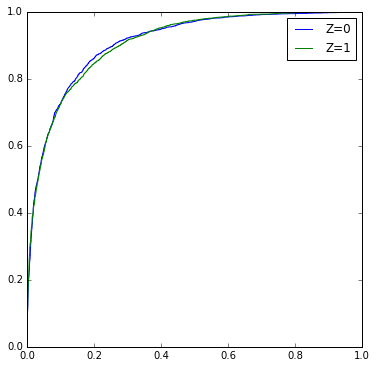

In [50]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_z0, D.predict(X_test_z0))
plt.plot(fpr, tpr, label="Z=0")
fpr, tpr, _ = roc_curve(y_test_z1, D.predict(X_test_z1))
plt.plot(fpr, tpr, label="Z=1")
plt.legend()
plt.show()

In [51]:
# Pretraining of R
D.trainable = False
R.trainable = True
DfR.fit(X_train, z_train, nb_epoch=5)

Epoch 1/5
1616476/1616476 [==============================] - 21s - loss: 0.6927    
Epoch 2/5
1616476/1616476 [==============================] - 21s - loss: 0.6926    
Epoch 3/5
1616476/1616476 [==============================] - 21s - loss: 0.6925    
Epoch 4/5
1616476/1616476 [==============================] - 21s - loss: 0.6925    
Epoch 5/5
1616476/1616476 [==============================] - 22s - loss: 0.6924    


In [52]:
from IPython import display

from scipy.stats import entropy
min_Lr = entropy([1. / 2] * 2)

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    #plt.axhline(y=min_Lf, ls="dashed")
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    plt.axhline(y=min_Lr, ls="dashed")
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    
    ax3 = plt.subplot(313, sharex=ax1)
    #plt.axhline(y=min_Lf - lam*min_Lr, ls="dashed")
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    
    plt.show()   

In [53]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

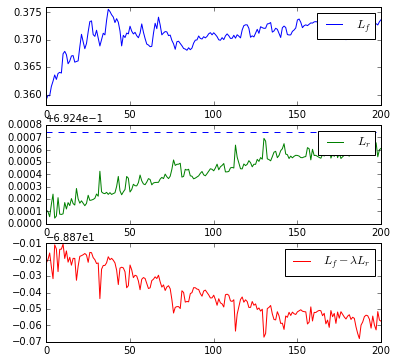

In [54]:
batch_size = 128

for i in range(201):
    l = DRf.evaluate(X_test, [y_test, z_test], verbose=0)    
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    if i % 5 == 0:
        plot_losses(i, losses)
    
    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X_train))[:batch_size]
    DRf.train_on_batch(X_train[indices], [y_train[indices], z_train[indices]])
    
    # Fit R
    D.trainable = False
    R.trainable = True
    
    for j in range(100):
        indices = np.random.permutation(len(X_train))[:batch_size]
        DfR.train_on_batch(X_train[indices], z_train[indices])

In [55]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, D.predict(X_test))

0.90145348184298735

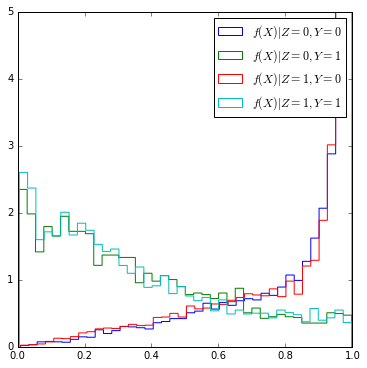

In [56]:
plt.hist(1. - D.predict(X_test_z0[y_test_z0 == 0]), bins=40, normed=1, histtype="step", label="$f(X)|Z=0,Y=0$")
plt.hist(1. - D.predict(X_test_z0[y_test_z0 == 1]), bins=40, normed=1, histtype="step", label="$f(X)|Z=0,Y=1$")
plt.hist(1. - D.predict(X_test_z1[y_test_z1 == 0]), bins=40, normed=1, histtype="step", label="$f(X)|Z=1,Y=0$")
plt.hist(1. - D.predict(X_test_z1[y_test_z1 == 1]), bins=40, normed=1, histtype="step", label="$f(X)|Z=1,Y=1$")
plt.legend(loc="best")
plt.ylim(0, 5.)
plt.show()

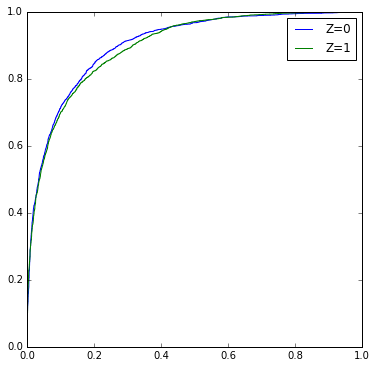

In [57]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_z0, D.predict(X_test_z0))
plt.plot(fpr, tpr, label="Z=0")
fpr, tpr, _ = roc_curve(y_test_z1, D.predict(X_test_z1))
plt.plot(fpr, tpr, label="Z=1")
plt.legend()
plt.show()